In [31]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
from dataprep import *
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
#from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

In [15]:
#train_adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [32]:
pericellular_dict = subsetGenes(adata, 'pericellular', 0.9, 11, 'low')

In [33]:
random_dict_mixed = subsetGenes(adata, 'random', 0.9, 11, 'low', mixed_counts=True)

In [34]:
random_dict_low = subsetGenes(adata, 'random', 0.9, 11, 'low', False)

## Plan of attack

1. predict all the items within a single dictionary.
2. Do the same for the random genes.
3. group results together in a dataframe. Columns: RF_results, group, pattern (so can subset for the patterns when doing regression)
4. do logistic regression on the dataframe to see if there is a significant difference

## Check f1 score for protrusion data with pattern strength 0.45 iso 0.9

In [59]:
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [72]:
adata_all[adata_all.obs['pattern']=='protrusion']

View of AnnData object with n_obs × n_vars = 0 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    uns: 'neighbors', 'pattern_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [73]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd

In [74]:
adata_concat = ad.concat([adata_all,adata_protrude], merge="same")
adata_concat[adata_concat.obs['pattern']=='protrusion']

View of AnnData object with n_obs × n_vars = 37979 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    obsm: 'latent'

In [70]:
protrude_adata = adata[adata.obs['pattern']=='protrusion']
adata_protrude = protrude_adata[protrude_adata.obs['prop']==0.4]
adata_protrude

View of AnnData object with n_obs × n_vars = 37979 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths'
    obsm: 'latent'

In [78]:
# Step 1: Group indices by cell_id
all_indices = adata_concat.obs.index
cell_ids = np.array(adata_concat.obs['cell_id'])
unique_cell_ids, cell_id_indices = np.unique(cell_ids, return_inverse=True)

# Step 3: Perform train-val-test split on cell_ids, maintaining the grouping
train_indices, test_val_indices = skm.train_test_split(np.arange(len(unique_cell_ids)), test_size=0.2, random_state=seed)
val_indices, test_indices = skm.train_test_split(test_val_indices, test_size=0.5, random_state=seed)

# Step 4: Map the grouped indices back to the original indices
train_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in train_indices])
val_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in val_indices])
test_indices = np.concatenate([np.where(cell_id_indices == i)[0] for i in test_indices])

# Step 5: Subset AnnData object using the obtained indices
adata_train = adata_concat[train_indices, :] # Training set:   176162 x 15
adata_val = adata_concat[val_indices, :]     # Validation set: 22269 x 15
adata_test = adata_concat[test_indices, :]   # Test set:       22256 x 15

In [79]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_val_pattern = adata_val.copy()
adata_val_pattern = adata_val_pattern[adata_val_pattern.obs['pattern']!='random']

<ipython-input-80-5f17c46949c9>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train_pattern.obs["protrusion"] = np.where(adata_train_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
<ipython-input-80-5f17c46949c9>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_val_pattern.obs["protrusion"] = np.where(adata_val_pattern.obs["pattern"] == "protrusion", "protrusion", "other")


f1 score: 
0.8601307189542483


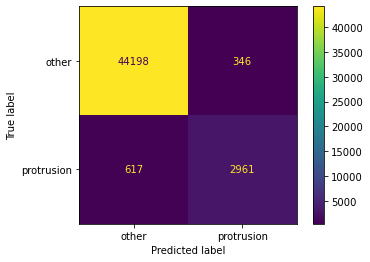

In [80]:
adata_train_pattern.obs["protrusion"] = np.where(adata_train_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
adata_val_pattern.obs["protrusion"] = np.where(adata_val_pattern.obs["pattern"] == "protrusion", "protrusion", "other")
 # create random forest classifier EXCLUDING random
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["protrusion"]) 
    
#predict label
val_protrusion = rf_classifier.predict(adata_val_pattern.obsm["latent"])

print("f1 score: ")
print(f1_score(adata_val_pattern.obs["protrusion"], val_protrusion, pos_label='protrusion'))

confusion_matrix = metrics.confusion_matrix(adata_val_pattern.obs["protrusion"], val_protrusion, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

## Load RF trained objects

In [9]:
# create random forest classifier and fit on training data
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False)
rf_classifier.fit(train_adata.obsm["latent"], train_adata.obs["random_or_pattern"])
    
#predict label

RandomForestClassifier(max_features=3, n_estimators=150, random_state=101)

In [ ]:
rf_classifier

In [16]:
random_pred = rf_classifier.predict(random_dict_mixed.get(0).obsm["latent"])
pericellular_pred = rf_classifier.predict(pericellular_dict.get(0).obsm["latent"])

In [19]:
np.unique(pericellular_pred)

array(['pattern'], dtype=object)

In [22]:
from collections import Counter
Counter(random_pred)

Counter({'random': 251, 'pattern': 66})

In [24]:
random_low_pred = rf_classifier.predict(random_dict_low.get(0).obsm["latent"])
Counter(random_low_pred)

Counter({'random': 21, 'pattern': 232})

In [41]:
import pickle

patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
models = {}

for pattern in patterns:
    # Specify the path where the model is saved
    path = f"temp_objects/rf_{pattern}.pkl"

    # Open the file in read-binary mode and load the model
    with open(path, 'rb') as p:
        models[pattern] = pickle.load(p)

In [24]:
models.get('pericellular').predict_proba(random_dict_mixed.get(0).obsm["latent"])

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99333333, 0.00666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99333333, 0.00666667],
       [1.        , 0.        ],
       [0.98      , 0.02      ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.

In [49]:
models.get('pericellular').predict_proba(pericellular_dict.get(0).obsm["latent"])

array(['other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other',
       'pericellular', 'other', 'pericellular', 'other', 'other', 'other',
       'pericellular', 'other', 'other', 'other', 'pericellular',
       'pericellular', 'other', 'other', 'pericellular', 'other',
       'pericellular', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'pericellular', 'other',
       'other', 'other', 'other', 'other', 'other', 'pericellular',
       'other', 'other', 'pericellular', 'other', 'other', 'other',
       'other', 'other', 'other', 'other', 'other', 'other', 'other',
       'other', 'other', 'other', 'pericellular', 'other', 'other',
       'pericellular', 'other', 'other', 'other', 'other', 'pericellular',
       'other', 'other', 'other', 'other', 'other', 'pericellular',
       'other', 'other', 'pericellular', 'other', 'other', 'pericellular',
       'other', 'other', 'other', 

In [40]:
from collections import Counter
print(Counter(models.get('pericellular').predict(pericellular_dict.get(3).obsm["latent"])))
print(Counter(models.get('pericellular').predict(random_dict_mixed.get(3).obsm["latent"])))
print(Counter(models.get('pericellular').predict(random_dict_low.get(3).obsm["latent"])))

Counter({'other': 229, 'pericellular': 29})
Counter({'other': 317})
Counter({'other': 252, 'pericellular': 1})


In [53]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [79]:
rows = []

gene_id = np.array(range(10))
for pattern in patterns:
    for i in range(10):
        pericellular = models.get(pattern).predict_proba(pericellular_dict.get(i).obsm["latent"])[:,0]
        random_mixed = models.get(pattern).predict_proba(random_dict_mixed.get(i).obsm["latent"])[:,0]
        random_low = models.get(pattern).predict_proba(random_dict_low.get(i).obsm["latent"])[:,0]
        for value in pericellular:
            rows.append({'prob_pattern': value, 'group': 'pericellular', 'pattern': pattern, 'gene_id': i})
        for value in random_mixed:
            rows.append({'prob_pattern': value, 'group': 'random_mixed', 'pattern': pattern, 'gene_id': i})
        for value in random_low:
            rows.append({'prob_pattern': value, 'group': 'random_low', 'pattern': pattern, 'gene_id': i})
df = pd.DataFrame(rows)

In [97]:
df[df['pattern']=='protrusion']

,prob_pattern,group,pattern,gene_id
58048,0.946667,pericellular,protrusion,0
58049,0.993333,pericellular,protrusion,0
58050,0.960000,pericellular,protrusion,0
58051,0.486667,pericellular,protrusion,0
58052,1.000000,pericellular,protrusion,0
...,...,...,...,...
65299,1.000000,random_low,protrusion,9
65300,0.973333,random_low,protrusion,9
65301,1.000000,random_low,protrusion,9
65302,1.000000,random_low,protrusion,9


In [82]:
import statsmodels.formula.api as smf

In [85]:
model = smf.ols("prob_pattern ~ group + gene_id", data= df[df['pattern'] == 'pericellular']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           prob_pattern   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     2485.
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:46:24   Log-Likelihood:                 5695.5
No. Observations:                7256   AIC:                        -1.138e+04
Df Residuals:                    7252   BIC:                        -1.136e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7374      0.003    244.876      0.000       0.731       0.743
group[T.random_low]       0.2266      0.003     65.606      0.000       0.220       0.233
group[T.random_mixed]     0.2603      0.003     82.671      0.000       0.254       0.266
gene_id                  -0.0002      0.000     -0.364      0.716      -0.001       0.001
==============================================================================
Omnibus:                     2520.897   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14825.853
Skew:                          -1.545   Prob(JB):                         0.00
Kurtosis:                       9.284   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
from scipy import stats

Text(0.5, 1.0, 'Model1 Residuals Q-Q Plot')

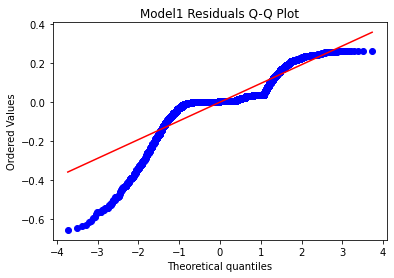

In [89]:
#Running plot & giving it a title
stats.probplot(model.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")


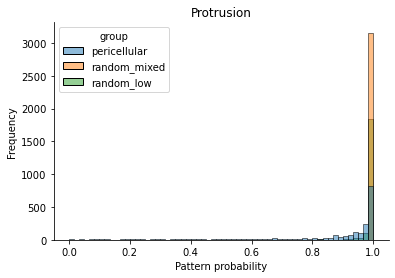

In [143]:
import seaborn as sns

ax = sns.histplot(x='prob_pattern', hue='group', data=df[df['pattern'] == 'protrusion'], bins=60)

ax.set(xlabel ="Pattern probability", 
                ylabel = "Frequency", title="Protrusion")

sns.despine()

In [130]:
import matplotlib.pyplot as plt

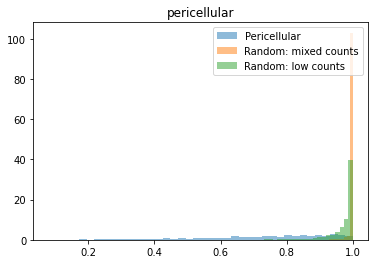

In [138]:
# Assuming data1, data2, data3 are your groups
pattern = 'pericellular'
pericellular = df[(df['pattern'] == pattern) & (df['group']=='pericellular')]
random_mixed = df[(df['pattern'] == pattern) & (df['group']=='random_mixed')]
random_low = df[(df['pattern'] == pattern) & (df['group']=='random_low')]

plt.hist(pericellular['prob_pattern'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(random_mixed['prob_pattern'], bins=40, alpha=0.5, label='Random: mixed counts', density=True)
plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title(pattern)
plt.legend(loc='upper right')
plt.show()

In [141]:
pericellular = df[(df['pattern'] == 'pattern') & (df['group']=='pericellular')]
random_mixed = df[(df['pattern'] == pattern) & (df['group']=='random_mixed')]
random_low = df[(df['pattern'] == pattern) & df['group']=='random_low']
random_mixed['prob_pattern']

43794    1.000000
43795    0.986667
43796    1.000000
43797    1.000000
43798    1.000000
           ...   
50635    1.000000
50636    1.000000
50637    1.000000
50638    1.000000
50639    1.000000
Name: prob_pattern, Length: 3170, dtype: float64

In [ ]:
'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion'